In [1]:
import random
import warnings
import numpy as np
import matplotlib.pyplot as plt
import dataLoader as dl

#from Inner_Speech_Dataset.Plotting.ERPs import 
from Inner_Speech_Dataset.Python_Processing.Data_extractions import  Extract_data_from_subject
from Inner_Speech_Dataset.Python_Processing.Data_processing import  Select_time_window, Transform_for_classificator, Split_trial_in_time


In [2]:
#Loading the data and labels from EEG and EXG
 
data1, labels1 = dl.load_data(datatype="EEG", subject_nr=1, verbose=True) 
data2, labels2 = dl.load_data(datatype="EEG", subject_nr=2 ,verbose=True) 
data4 , labels4 = dl.load_data(datatype="EEG", subject_nr=4, verbose=True) 

dataX, labelsX = dl.load_data(datatype="EXG", verbose=False) 
#dl.load_data(datatype2=2) #4.5 is max

data = np.concatenate([data1, data2, data4], axis = 0)
labels1d = np.concatenate([labels1, labels2, labels4], axis = 0)
labels = np.zeros([labels1d.shape[0], 2])
for row, label in enumerate(labels1d,0):
    if label == 0:
        labels[row,0] = 1
    if label == 1:
        labels[row,1] = 1

Data shape: [trials x channels x samples]
(500, 128, 1153)
Labels shape
(500, 4)
Final data shape
(100, 128, 1153)
Final labels shape
(100,)
Up is 0.0 and Down is 1.0
Data shape: [trials x channels x samples]
(600, 128, 1153)
Labels shape
(600, 4)
Final data shape
(120, 128, 1153)
Final labels shape
(120,)
Up is 0.0 and Down is 1.0
Data shape: [trials x channels x samples]
(600, 128, 1153)
Labels shape
(600, 4)
Final data shape
(120, 128, 1153)
Final labels shape
(120,)
Up is 0.0 and Down is 1.0
Up is 0.0 and Down is 1.0


In [3]:
#Splitting into training and test data
#print(labels)


order = np.arange(labels.shape[0])
np.random.shuffle(order)

temp_data = np.zeros(data.shape)
temp_labels = np.zeros(labels.shape)

for x in range(labels.shape[0]):
    i = order[x]
    
    temp_data[x] = data[i]
    temp_labels[x] = labels[i]

data = temp_data
labels = temp_labels

data_train, data_test = np.split(data, indices_or_sections=[int(labels.shape[0]*0.75)],axis=0)
labels_train, labels_test = np.split(labels, indices_or_sections=[int(labels.shape[0]*0.75)],axis=0)
print(labels_train.shape)
print(data_test.shape)

print(labels)



(255, 2)
(85, 128, 1153)
[[1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0

In [4]:


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

tf.keras.backend.clear_session()

#Convolution part


convlayer = tf.keras.layers.Conv2D(1,
 kernel_size=[16,1], input_shape= (255, 128 , 1153, 1,), 
 padding="valid", strides=4
 activation="relu")

print(data_train.shape)
print(data_test.shape)

#data_train = np.swapaxes(data_train, 2, 1)
#data_test = np.swapaxes(data_test, 2, 1)
print(data_train.shape)
print(data_test.shape)
data_train = np.expand_dims(data_train, axis=0)
data_test = np.expand_dims(data_test, axis=0)
data_train = np.moveaxis(data_train, 0, -1)
data_test = np.moveaxis(data_test, 0, -1)

conv_data_train = convlayer(data_train)
conv_data_test = convlayer(data_test)

data_train = conv_data_train
data_test = conv_data_test

#data_train = np.swapaxes(data_train, 2, 1)
#data_test = np.swapaxes(data_test, 2, 1)


data_train = np.squeeze(np.moveaxis(data_train, -1, 0))
data_test = np.squeeze(np.moveaxis(data_test, -1, 0))
print(data_train.shape)
print(data_test.shape)



eeg_model = tf.keras.Sequential([
    layers.Dense(input_shape = (data_train.shape[1],data_train.shape[2]), units=1024, activation="relu"),
    layers.Dropout(0.05),
    layers.Dense(units=1024, activation="relu"),
    layers.Dropout(0.05),
    layers.Dense(units=512, activation="relu"),
    layers.Dropout(0.05),
    layers.Flatten(input_shape = (16,512)),
    layers.Dense(units=2, activation="softmax")


])
eeg_model.build()
eeg_model.summary()



(255, 128, 1153)
(85, 128, 1153)
(255, 128, 1153)
(85, 128, 1153)
(255, 113, 1152)
(85, 113, 1152)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 113, 1024)         1180672   
                                                                 
 dropout (Dropout)           (None, 113, 1024)         0         
                                                                 
 dense_1 (Dense)             (None, 113, 1024)         1049600   
                                                                 
 dropout_1 (Dropout)         (None, 113, 1024)         0         
                                                                 
 dense_2 (Dense)             (None, 113, 512)          524800    
                                                                 
 dropout_2 (Dropout)         (None, 113, 512)          0         
                       

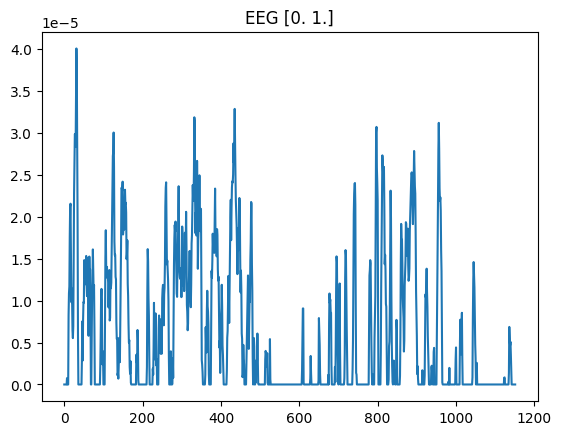

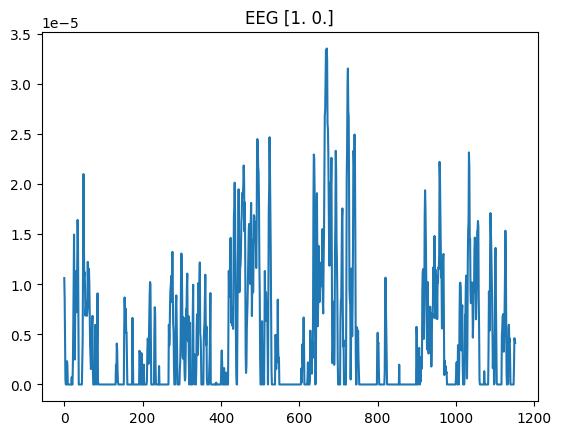

In [5]:
for trialNr, trial in enumerate(data_train[44:46],44):
    for channel in trial[5:6]:
        plt.figure()
        plt.plot(channel)
        plt.title("EEG {}".format(labels_train[trialNr]))

In [6]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, )

eeg_model.compile(optimizer='adam',
              loss="binary_crossentropy",
              metrics=['accuracy'])

eeg_model.fit(data_train, labels_train, callbacks=[callback],epochs=100)

print("Results")
eeg_model.evaluate(data_test, labels_test)
result = eeg_model.predict(data_test)


Epoch 1/100
8/8 [==============================] - 3s 240ms/step - loss: 0.6945 - accuracy: 0.4706
Epoch 2/100
8/8 [==============================] - 2s 243ms/step - loss: 0.6940 - accuracy: 0.5059
Epoch 3/100
8/8 [==============================] - 2s 239ms/step - loss: 0.6930 - accuracy: 0.5059
Epoch 4/100
8/8 [==============================] - 2s 251ms/step - loss: 0.6936 - accuracy: 0.4078
Epoch 5/100
8/8 [==============================] - 2s 231ms/step - loss: 0.6931 - accuracy: 0.5647
Epoch 6/100
8/8 [==============================] - 2s 240ms/step - loss: 0.6933 - accuracy: 0.5059
Epoch 7/100
8/8 [==============================] - 2s 235ms/step - loss: 0.6933 - accuracy: 0.5059
Epoch 8/100
8/8 [==============================] - 2s 230ms/step - loss: 0.6932 - accuracy: 0.5059
Epoch 9/100
8/8 [==============================] - 2s 234ms/step - loss: 0.6932 - accuracy: 0.5059
Epoch 10/100
8/8 [==============================] - 2s 237ms/step - loss: 0.6931 - accuracy: 0.5059
Epoch 11/

In [7]:
result2 = []
print(result)
for res in result:
    x = np.maximum(res[0], res[1])
    result2.append(int(np.where(res == x)[0]))

result2 = np.array(result2)
print(result2)

[[0.4947232  0.50527686]
 [0.4947233  0.5052768 ]
 [0.4947232  0.5052768 ]
 [0.49472326 0.50527674]
 [0.49472335 0.5052767 ]
 [0.49472335 0.50527674]
 [0.49472326 0.50527674]
 [0.49472332 0.50527674]
 [0.4947233  0.5052768 ]
 [0.4947233  0.5052768 ]
 [0.49472323 0.5052768 ]
 [0.49472344 0.50527656]
 [0.4947232  0.50527686]
 [0.4947232  0.50527686]
 [0.4947234  0.5052767 ]
 [0.49472326 0.5052768 ]
 [0.49472314 0.50527686]
 [0.49472335 0.50527656]
 [0.4947232  0.5052768 ]
 [0.49472302 0.50527704]
 [0.4947233  0.5052768 ]
 [0.49472314 0.50527686]
 [0.49472335 0.50527674]
 [0.49472335 0.50527674]
 [0.4947233  0.5052768 ]
 [0.49472332 0.5052767 ]
 [0.49472326 0.50527674]
 [0.49472335 0.5052767 ]
 [0.49472332 0.50527674]
 [0.4947233  0.5052768 ]
 [0.49472317 0.5052769 ]
 [0.4947232  0.50527686]
 [0.49472332 0.5052767 ]
 [0.49472332 0.50527674]
 [0.49472302 0.50527704]
 [0.49472338 0.5052767 ]
 [0.49472332 0.5052767 ]
 [0.49472332 0.50527674]
 [0.4947233  0.5052768 ]
 [0.49472335 0.5052767 ]


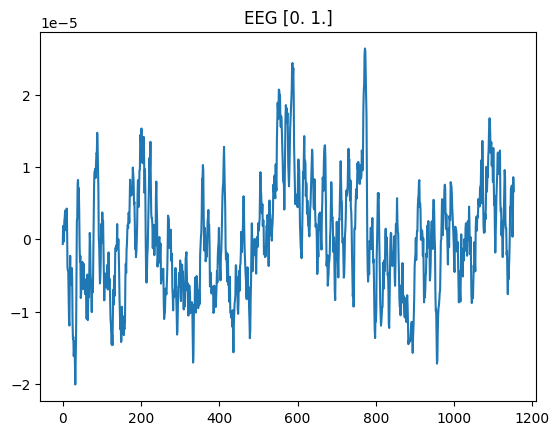

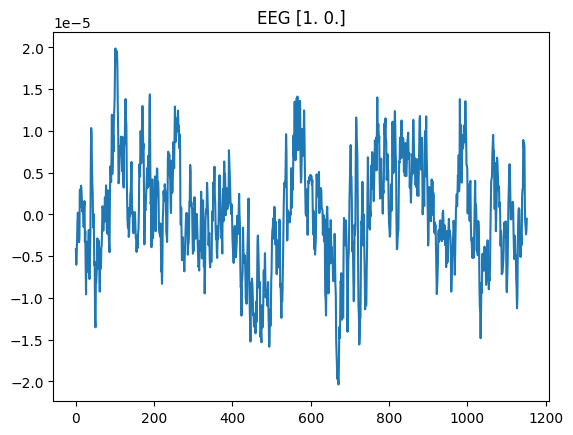

In [8]:


for trialNr, trial in enumerate(data[44:46],44):
    for channel in trial[5:6]:
        plt.figure()
        plt.plot(channel)
        plt.title("EEG {}".format(labels[trialNr]))

      